In [1]:
from datagenerator import DataGen
import numpy as np
import tensorflow as tf
import scipy as sc
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.metrics import pairwise_distances
import tqdm
%matplotlib inline

from IPython import display

tf.enable_eager_execution()

In [2]:
def single_chi_sq_dist(x, y):
    return 0.5 * np.sum((x-y)**2 / (x+y+1e-20))

def chi_sq_dist(X):
    X_1 = tf.expand_dims(X, 1)
    X_2 = tf.expand_dims(X, 0)

    epsilon = tf.constant(0.000001)
    
    return 0.5 * tf.reduce_sum(tf.squared_difference(X_1, X_2) / (X_1+X_2 + epsilon), 2)

def chi_sq_nn(X):
    with tf.device("/cpu:0"):
        dist = chi_sq_dist(X)
        return np.argsort(np.abs(dist),axis=1)

def euclidean_nn(X):
    dist = distance_matrix(X,X)
    return np.argsort(dist,axis=1)

In [7]:
a = np.load("amazon_data.npz")
X =a["X"]
y = a["y"]

dims = X.shape[1]
K = 3

X = X / np.tile(np.sum(X, axis=1), (dims, 1)).T
num_classes = len(np.unique(y))

In [8]:
#N=100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = X_train#[:N]
y_train = y_train#[:N]
X_test = X_test#[:N]
y_test = y_test#[:N]


In [9]:
""" NN keras
catsdf = pd.read_csv("data/cats.csv")
dogsdf = pd.read_csv("data/dogs.csv")
X = np.concatenate([catsdf.values, dogsdf.values])
y = np.array(len(catsdf)*[1]+ len(catsdf)*[0])

tmp = np.tile(np.sum(X, axis=1), (dims, 1)).T
X = X / tmp
"""

' NN keras\ncatsdf = pd.read_csv("data/cats.csv")\ndogsdf = pd.read_csv("data/dogs.csv")\nX = np.concatenate([catsdf.values, dogsdf.values])\ny = np.array(len(catsdf)*[1]+ len(catsdf)*[0])\n\ntmp = np.tile(np.sum(X, axis=1), (dims, 1)).T\nX = X / tmp\n'

In [10]:
data =np.load("./surf_histograms_800.npz")
X_train = data['X_train'][:200]
y_train = data['y_train'][:200].astype(np.int)
X_test = data['X_test'][:200]
y_test = data['y_test'][:200].astype(np.int)

uniq, count = np.unique(y_train, return_counts=True)
for u, c in zip(uniq, count):
    if c < 5:
        X_train = X_train[y_train  != int(u)]
        y_train = y_train[y_train != int(u)]
        X_test = X_test[y_test != int(u)]
        y_test = y_test[y_test != int(u)]

N = len(X_train)
num_classes = len(np.unique(y_train))
dims = X_train.shape[1]

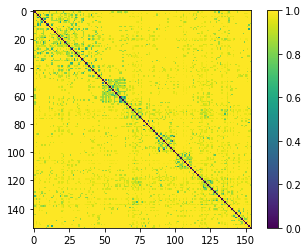

In [11]:
idx = np.argsort(y_train)

plt.imshow(pairwise_distances(X_train[idx,:], metric=single_chi_sq_dist))
plt.colorbar()

In [12]:
#X, y = DataGen.gauss(100, 3)
#X, y = DataGen.moons(100,0.5)

#X, y = DataGen.gauss(100, 2)
#X, y = load_iris(return_X_y=True)
#X, y = X[:100], y[:100]
#X = np.hstack((X,np.zeros((X.shape[0],1))))
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#X, y = X_train, y_train


#D = chi_sq_dist(X)
#plt.imshow(D)

In [28]:
def compute_knn_accuracy(X_train, y_train, X_test, y_test):
    knc = KNeighborsClassifier(n_neighbors=K, algorithm='ball_tree', metric='pyfunc', 
                           metric_params={'func': single_chi_sq_dist})
    knc.fit(X_train, y_train)
    y_hat = knc.predict(X_test)
    return np.sum(y_hat == y_test) / len(y_test)
print(f"Train_accu: {compute_knn_accuracy(X_train, y_train, X_train, y_train)}, "+
      f"Test_accu: {compute_knn_accuracy(X_train, y_train, X_test, y_test)}")

Train_accu: 0.7987012987012987, Test_accu: 0.6241610738255033


In [14]:
nearest_points = chi_sq_nn(X_train.astype('float32'))
#nearest_points = euclidean_nn(X.astype('float32'))


In [15]:
## Same Class Neighbors - Automatic v2.0
nn = np.zeros((N*K,2), dtype=np.int32)
for i in range(N):
    tmp = nearest_points[i]
    idx = [elem for elem in tmp if elem in np.where(y_train==y_train[i])[0]]
    nn[i::N,1] = idx[1:K+1]
    nn[i::N,0] = np.repeat(idx[0], K)

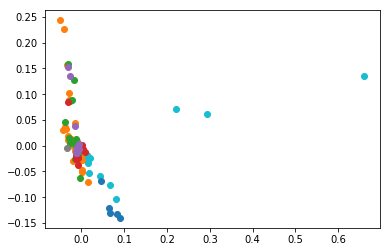

In [16]:
def plot_func(X,y):
    classes = np.unique(y)
    #plt.axis('equal')
    tmp = X.copy()
    tmp[:, 0] = X[:, 0] / X[:, 2]
    tmp[:, 1] = X[:, 1] / X[:, 2]
    
    for i in classes:
        plt.plot(tmp[y==i,0], tmp[y==i,1],'.')
    #plt.show()

t = 5
pca = PCA(2)
pca.fit(X_train)
trans_X_train = pca.transform(X_train)

for i in range(num_classes):
    plt.plot(trans_X_train[y_train==i,0], trans_X_train[y_train==i,1] , 'o')
#plt.plot(X[int(nn[t,0]),0],X[int(nn[t,0]),1],'x')
#plt.plot(X[nn[t,1:].astype(np.int),0],X[nn[t,1:].astype(np.int),1],'*')
#plt.plot(X[im[t,:].astype(np.int),0],X[im[t,:].astype(np.int),1],'*')
plt.show()


In [17]:
def get_impostors(D, nn, y, margin):
    N = np.shape(D)[0]
    idxs = tf.reshape(tf.tile(tf.range(N),[N*K]), (N*N*K,1))
    tn_idxs = tf.reshape(tf.tile(nn, [1, N]), (-1, 2))
    all_idxs = tf.concat([tn_idxs, idxs], axis=1)

    tn_index = all_idxs[:,:2]
    im_index = all_idxs[:,::2]
    tn_distance = tf.gather_nd(D, tn_index)
    im_distance = tf.gather_nd(D, im_index)
    
    is_too_close = im_distance <= margin + tn_distance
    is_different_class = tf.not_equal(tf.gather(y, tn_index[:,1]), tf.gather(y, im_index[:,1]))

    predicate = tf.logical_and(is_too_close, is_different_class)
    #print(tf.reduce_sum(tf.cast(predicate, tf.int32)))
    return tf.boolean_mask(all_idxs, predicate) # (idx, target neighbour index, imposter index)

def loss(X, A, nn, y, margin):
    L = tf.nn.softmax(A,axis=0)
    #X_bar = tf.cast(X @ L, tf.float32)
    X_bar = tf.cast(X @ tf.transpose(L), tf.float32)
    
    D = chi_sq_dist(X_bar)
    
    im_triple = get_impostors(D, nn, y, margin)
    #print(im_triple)
    
    pull_term = tf.gather_nd(D, nn) # (N*K, 1) where each element 
    pull_loss = tf.reduce_sum(pull_term)

    push_loss = tf.reduce_sum(margin + tf.gather_nd(D, im_triple[:,:2]) - tf.gather_nd(D, im_triple[:,::2]))
    #print(push_loss)
    loss = pull_loss + mu * push_loss
    return loss

def grad(X, A, nn, y, margin):
    with tf.GradientTape() as tape:
        loss_value = loss(X, A, nn, y, margin)
    return tape.gradient(loss_value, A)

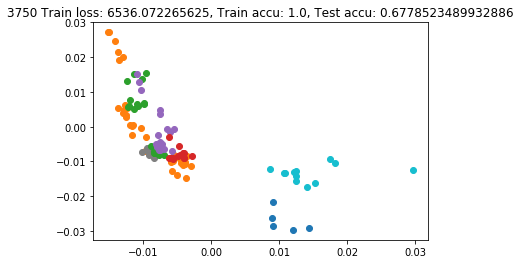


 38%|███▊      | 3770/10000 [38:27<45:53,  2.26it/s]

In [ ]:
r = dims
A = tf.Variable(np.eye(r, dims) + 0.01* np.ones((r,dims)))
#A = tf.Variable(tf.random.uniform((r,dims)))

#margin = 0.5
#margin = 0.001
margin = .1
mu = 1

#optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
train_losses = []
test_accuracies = []
train_accuracies = []
#plot_func(X @ np.array(tf.nn.softmax(A,axis=0)), y)
with tf.device("/cpu:0"):
    for i in tqdm.tqdm(range(10000)):
        grads = grad(X_train, A, nn, y_train, margin)
        optimizer.apply_gradients(zip([grads], [A]))

        if i % 50 == 0:
            train_loss = loss(X_train, A, nn, y_train, margin).numpy()
            train_losses.append(tra_loss)
            train_accu = compute_knn_accuracy(X_train @ L.T, y_train, X_train @ L.T, y_train)
            test_accu = compute_knn_accuracy(X_train @ L.T, y_train, X_test @ L.T, y_test)
            test_accuracies.append(test_accu)
            train_accuracies.append(train_accu)
            plt.figure()
            plt.title(f"{i} Train loss: {tra_loss}, Train accu: {train_accu}, Test accu: {test_accu}")
            L = np.array(tf.nn.softmax(A,axis=0))
            x_bar = X_train @ L.T
            trans_X_train = pca.transform(x_bar)

            for i in range(num_classes):
                plt.plot(trans_X_train[y_train==i,0], trans_X_train[y_train==i,1] , 'o')
            #plot_func(X @ np.array(tf.nn.softmax(A,axis=0)),y)
            #plt.title(loss(X, A, nn, y, margin).numpy())

            display.clear_output(wait=True)
            display.display(plt.gcf())
        

#optimizer.minimize(loss)

In [24]:
compute_knn_accuracy(X_train @ L.T, y_train, X_test @ L.T, y_test)

0.6845637583892618

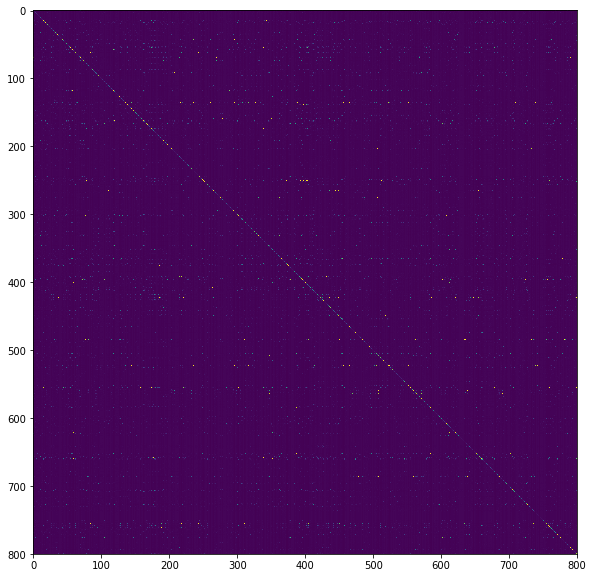

In [91]:
plt.figure(figsize=(10,10))
plt.imshow(L, vmin=0, vmax=0.1)

In [ ]:
t = X_train[:]/np.linalg.norm(X_train, axis=0)

In [20]:
np.save("A_roadsign.npy", A)

In [49]:
with open("A.npy", "rb") as f:
    a = np.load(f)
a

array(<tf.Variable 'Variable:0' shape=(800, 800) dtype=float64, numpy=
array([[ 7.98979736, -0.21010345, -1.32465445, ..., -0.44509852,
        -1.48639429,  6.74209132],
       [-0.50322698,  8.62433236, -2.01155783, ...,  1.5922618 ,
        -1.75252645,  0.37058134],
       [-0.99987465, -1.56868273,  5.95974234, ..., -1.84527481,
         2.83175927, -0.78584369],
       ...,
       [-1.58588671,  0.28598222, -1.87395204, ...,  7.61124701,
        -1.02477621, -1.03469683],
       [-1.31015668, -1.42490401,  1.39459866, ..., -1.61793875,
         4.27353209, -0.82286528],
       [ 0.06113732,  1.1305378 , -1.94691179, ...,  0.11980106,
        -1.71034241,  9.99979674]])>, dtype=object)

array([[ 7.98979736, -0.21010345, -1.32465445, ..., -0.44509852,
        -1.48639429,  6.74209132],
       [-0.50322698,  8.62433236, -2.01155783, ...,  1.5922618 ,
        -1.75252645,  0.37058134],
       [-0.99987465, -1.56868273,  5.95974234, ..., -1.84527481,
         2.83175927, -0.78584369],
       ...,
       [-1.58588671,  0.28598222, -1.87395204, ...,  7.61124701,
        -1.02477621, -1.03469683],
       [-1.31015668, -1.42490401,  1.39459866, ..., -1.61793875,
         4.27353209, -0.82286528],
       [ 0.06113732,  1.1305378 , -1.94691179, ...,  0.11980106,
        -1.71034241,  9.99979674]])

In [46]:
weights_placeholder = tf.placeholder((some_appropriate_shape))
assign_op = tf.assign(W, weights_placeholder)

IndexError: too many indices for array

In [61]:
tf.convert_to_tensor(A2.item().numpy())

<tf.Tensor: id=70, shape=(800, 800), dtype=float64, numpy=
array([[ 7.98979736, -0.21010345, -1.32465445, ..., -0.44509852,
        -1.48639429,  6.74209132],
       [-0.50322698,  8.62433236, -2.01155783, ...,  1.5922618 ,
        -1.75252645,  0.37058134],
       [-0.99987465, -1.56868273,  5.95974234, ..., -1.84527481,
         2.83175927, -0.78584369],
       ...,
       [-1.58588671,  0.28598222, -1.87395204, ...,  7.61124701,
        -1.02477621, -1.03469683],
       [-1.31015668, -1.42490401,  1.39459866, ..., -1.61793875,
         4.27353209, -0.82286528],
       [ 0.06113732,  1.1305378 , -1.94691179, ...,  0.11980106,
        -1.71034241,  9.99979674]])>

In [93]:
idx = np.argsort(y)
L = np.array(tf.nn.softmax(A2.item(),axis=0))
trans_dists = pairwise_distances(X[idx,:] @ L.T, metric=single_chi_sq_dist)
dists = pairwise_distances(X[idx,:], metric=single_chi_sq_dist)

AttributeError: 'ResourceVariable' object has no attribute 'item'

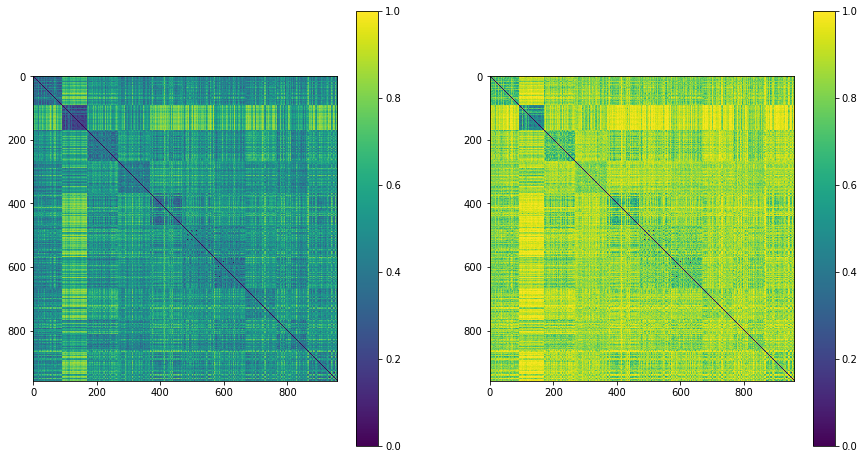

In [85]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(trans_dists, vmin=0, vmax=1)
plt.colorbar()
plt.subplot(122)
plt.imshow(dists, vmin=0, vmax=1)
plt.colorbar()

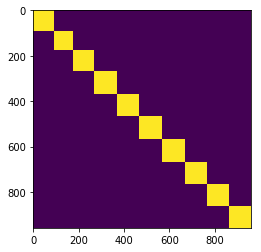

In [91]:
temp = np.zeros((len(X), len(X)))
current_idx = 0
trans_var = []
var = []
trans_means = []
means = []
for n in [sum(y==i) for i in np.unique(y)]:
    temp[current_idx:(current_idx+n), current_idx:(current_idx+n)] = 1
    trans_var.append(np.var(trans_dists[current_idx:(current_idx+n), current_idx:(current_idx+n)]))
    var.append(np.var(dists[current_idx:(current_idx+n), current_idx:(current_idx+n)]))
    trans_means.append(np.mean(trans_dists[current_idx:(current_idx+n), current_idx:(current_idx+n)]))
    means.append(np.mean(dists[current_idx:(current_idx+n), current_idx:(current_idx+n)]))
    current_idx+=n
plt.imshow(temp)

In [90]:
np.array(trans_var) < np.array(var)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False])

In [92]:
global_mean = np.mean(dists)
means / global_mean

array([0.82960503, 0.63205615, 0.85846525, 0.95082053, 0.88876304,
       0.91404035, 0.89561727, 0.97797041, 0.98296068, 0.96846266])

In [94]:
idx = np.argsort(y_train)
L = np.array(tf.nn.softmax(A,axis=0))
trans_dists = pairwise_distances(X_train[idx,:] @ L.T, metric=single_chi_sq_dist)
dists = pairwise_distances(X_train[idx,:], metric=single_chi_sq_dist)

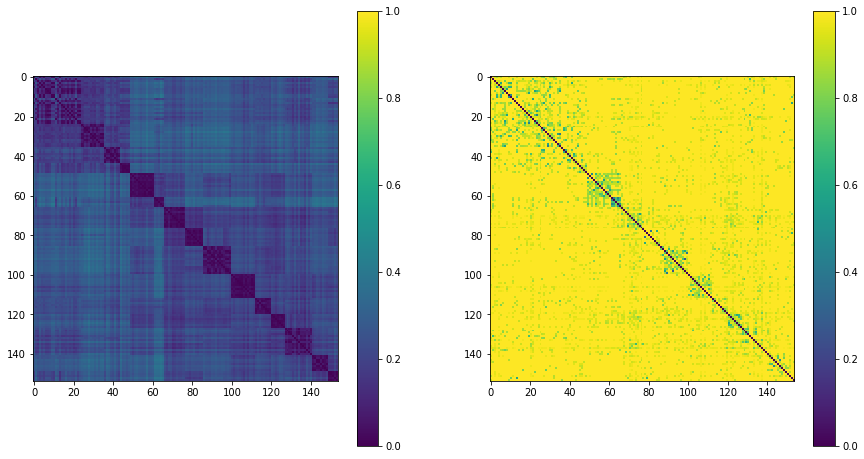

In [95]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(trans_dists, vmin=0, vmax=1)
plt.colorbar()
plt.subplot(122)
plt.imshow(dists, vmin=0, vmax=1)
plt.colorbar()

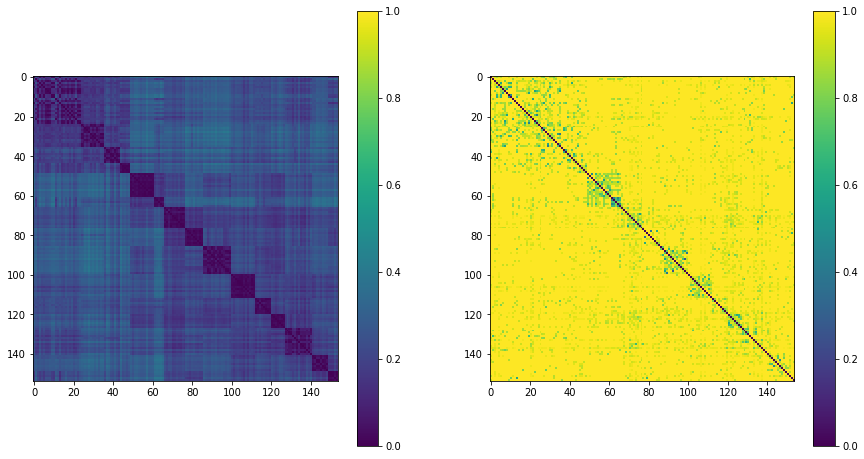

In [21]:
idx = np.argsort(y_train)
L = np.array(tf.nn.softmax(A,axis=0))
trans_dists = pairwise_distances(X_train[idx,:] @ L.T, metric=single_chi_sq_dist)
dists = pairwise_distances(X_train[idx,:], metric=single_chi_sq_dist)
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(trans_dists, vmin=0, vmax=1)
plt.colorbar()
plt.subplot(122)
plt.imshow(dists, vmin=0, vmax=1)
plt.colorbar()